In [97]:
#import all necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
sns.set(style="whitegrid")

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

In [49]:
#read our dataframe
clean = pd.read_csv('./Data & Figures/clean.csv', index_col = 0)
clean.head()

,price,price_log,sqft_above,sqft_above_log,sqft_lot,sqft_lot_log,sqft_living15,sqft_living15_log,sqft_lot15,age,...,zip_C,zip_D,zip_E,zip_F,zip_G,zip_H,zip_I,zipcode,lat,long
15937,268950.0,12.502281,880,6.779922,8100,8.999619,1000,6.907755,8100,72,...,0,0,1,0,0,0,0,98166,47.4697,-122.351
20963,399900.0,12.898970,900,6.802395,1005,6.912743,1440,7.272398,1188,4,...,0,0,0,0,1,0,0,98027,47.5446,-122.018
7614,339000.0,12.733755,720,6.579251,4128,8.325548,1510,7.319865,4538,73,...,0,0,0,0,0,0,0,98126,47.5296,-122.379
3257,380000.0,12.847927,840,6.733402,7372,8.905444,1930,7.565275,5150,76,...,0,0,0,0,0,0,0,98126,47.5285,-122.378
16723,365000.0,12.807653,1600,7.377759,4168,8.335192,1190,7.081709,4168,88,...,0,0,0,0,0,0,0,98126,47.5297,-122.381


In [50]:
clean.columns

Index(['price', 'price_log', 'sqft_above', 'sqft_above_log', 'sqft_lot',
       'sqft_lot_log', 'sqft_living15', 'sqft_living15_log', 'sqft_lot15',
       'age', 'bedrooms', 'bathrooms', 'floors', 'water_1.0', 'base_1.0',
       'reno_1.0', 'cond_2.0', 'cond_3.0', 'cond_5.0', 'zip_A', 'zip_B',
       'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I',
       'zipcode', 'lat', 'long'],
      dtype='object')

### Prepare Continuous Data: Feature Scaling

In [51]:
clean_continuous = clean[['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'age']]

In [52]:
# normalize (subract mean and divide by std)
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

clean_continuous_norm = clean_continuous.apply(normalize)

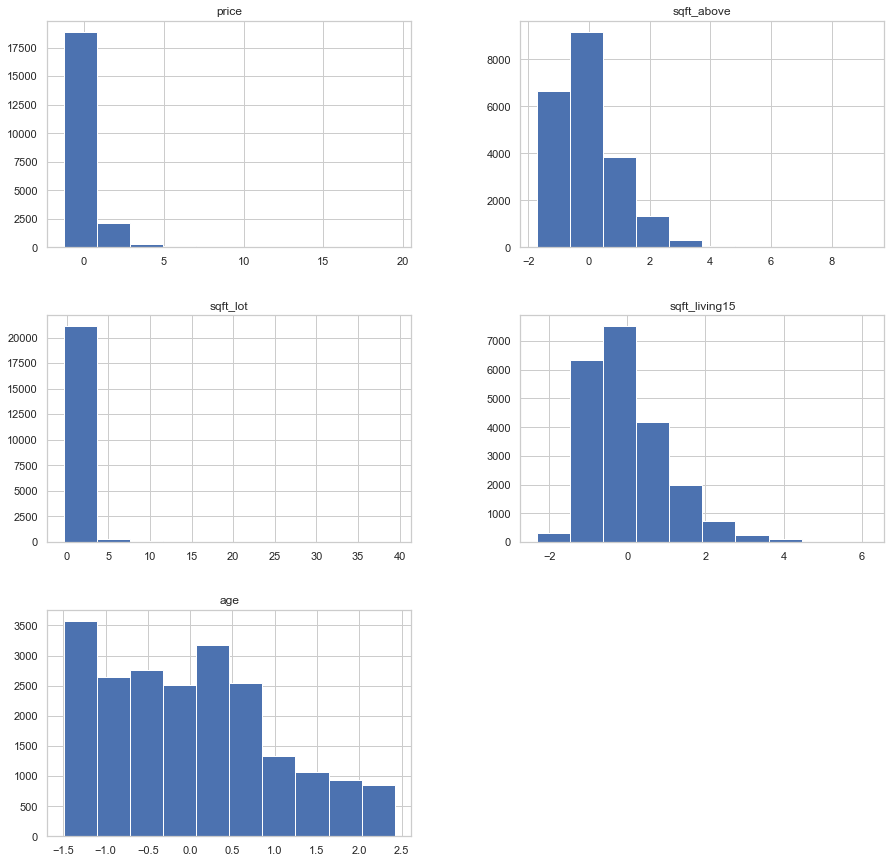

In [53]:
#plot the new normalized data
clean_continuous_norm.hist(figsize = (15, 15));

#save
plt.savefig('./Data & Figures/log_norm_histplot')

In [54]:
#drop old values
clean.drop(['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'age'], axis = 1, inplace = True)

In [55]:
#merge the newly normalized values
clean = pd.concat([clean, clean_continuous_norm], axis = 1) 

In [56]:
#review
clean.head()

,price_log,sqft_above_log,sqft_lot_log,sqft_living15_log,sqft_lot15,bedrooms,bathrooms,floors,water_1.0,base_1.0,...,zip_H,zip_I,zipcode,lat,long,price,sqft_above,sqft_lot,sqft_living15,age
15937,12.502281,6.779922,8.999619,6.907755,8100,3,1.00,1.0,0,1,...,0,0,98166,47.4697,-122.351,-0.740571,-1.099527,-0.169225,-1.441766,0.955962
20963,12.898970,6.802395,6.912743,7.272398,1188,2,1.75,1.5,0,1,...,0,0,98027,47.5446,-122.018,-0.384457,-1.075393,-0.340062,-0.799934,-1.357975
7614,12.733755,6.579251,8.325548,7.319865,4538,3,1.00,1.0,0,1,...,0,0,98126,47.5296,-122.379,-0.550073,-1.292602,-0.264865,-0.697824,0.989991
3257,12.847927,6.733402,8.905444,7.565275,5150,2,1.00,1.0,0,1,...,0,0,98126,47.5285,-122.378,-0.438575,-1.147796,-0.186754,-0.085165,1.092076
16723,12.807653,7.377759,8.335192,7.081709,4168,5,2.00,1.5,0,0,...,0,0,98126,47.5297,-122.381,-0.479367,-0.230689,-0.263901,-1.164611,1.500418


# MODEL A: 
## USING STEPWISE SELECTION
## WITH ALL FEATURES (p_value < 0.05) INCLUDED

In [57]:
#including all non-log-transformed features without neighborhood information
preprocessed_A = clean[['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15',
                      'age', 'bedrooms', 'bathrooms', 'floors', 
                      'water_1.0', 'base_1.0', 'reno_1.0',
                      'cond_2.0', 'cond_3.0', 'cond_5.0',
                      'zip_A', 'zip_B', 'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

With the linear regression, you would interpret log transformed variables as a percentage change. Here’s a quick breakdown: (http://data-slinky.com/2016/09/06/log_trans.html)

* If your response variable, y, is log-transformed and assuming you have one predictor, a unit increase in the predictor x is associated with the x’s coefficient, call it b1, (b1*100) percentage increase in y.
* If your predictor is log-transformed(e.g., log(x)), then one unit increase of x means a (b1/100) percent increase in y.
* If both the response and the predictor is log-transformed then a one percent increase in x means a b1 percent increase in y.

In [58]:
preprocessed_A.shape

(21420, 24)

In [59]:
X = preprocessed_A.drop(['price'], axis = 1)
y = preprocessed_A['price']

## Perform Stepwise Selection

In [60]:
#perform stepwise selection to ensure that we do not include any features with p-values of above 0.05 (learn.co)
def stepwise_selection(X, y, 
                       initial_list = [], 
                       threshold_in = 0.01, 
                       threshold_out = 0.05, 
                       verbose = True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index = excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [61]:
#apply function
result_A = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_A)

Add  sqft_above                     with p-value 0.0
Add  age                            with p-value 0.0
Add  water_1.0                      with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  zip_A                          with p-value 1.11522e-263
Add  zip_C                          with p-value 0.0
Add  sqft_living15                  with p-value 1.95187e-231
Add  zip_B                          with p-value 6.9763e-191
Add  bedrooms                       with p-value 6.00824e-95
Add  zip_G                          with p-value 9.03639e-88
Add  zip_F                          with p-value 4.2296e-16
Add  cond_3.0                       with p-value 7.71182e-17
Add  reno_1.0                       with p-value 5.11113e-13
Add  zip_E                          with p-value 5.54062e-09
Add  zip_I                          with p-value 6.78986e-10
Add  cond_5.0                       with p-value 1.06607e-07
Add  floor

In [62]:
#check out how many features satisfy p < 0.05
len(result_A)

19

## Build Model A

In [63]:
#build Model A in statsmodels
import statsmodels.api as sm

#interecept is not included by default and should be added manually
X_in = X[result_A]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_A = sm.OLS(y, X_intercept).fit() 

#get summary
model_A.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     2268.
Date:                Tue, 26 Jan 2021   Prob (F-statistic):               0.00
Time:                        21:36:18   Log-Likelihood:                -18578.
No. Observations:               21420   AIC:                         3.720e+04
Df Residuals:                   21400   BIC:                         3.736e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.5501      0.028    -19.884      0.000      -0.604      -0.496
sqft_above        0.5373      0.008     66.073      0.000       0.521       0.553
age               0.1431      0.006     23.120      0.000       0.131       0.155
water_1.0         2.3150      0.049     47.575      0.000       2.220       2.410
bathrooms         0.2142      0.009     23.157      0.000       0.196       0.232
base_1.0          0.3292      0.011     31.052      0.000       0.308       0.350
zip_A             0.7337      0.014     52.164      0.000       0.706       0.761
zip_C             0.7859      0.016     49.600      0.000       0.755       0.817
sqft_living15     0.1772      0.006     27.739      0.000       0.165       0.190
zip_B             0.4748      0.015     31.407      0.000       0.445       0.504
bedrooms         -0.1107      0.006    -19.977      0.000      -0.122      -0.100
zip_G             0.3447      0.017     19.784      0.000       0.311       0.379
zip_F            -0.0821      0.018     -4.685      0.000      -0.116      -0.048
cond_3.0         -0.0780      0.010     -7.753      0.000      -0.098      -0.058
reno_1.0          0.1798      0.023      7.865      0.000       0.135       0.225
zip_E             0.1390      0.019      7.259      0.000       0.101       0.176
zip_I             0.1622      0.026      6.268      0.000       0.111       0.213
cond_5.0          0.0838      0.016      5.160      0.000       0.052       0.116
floors           -0.0569      0.011     -5.387      0.000      -0.078      -0.036
cond_2.0         -0.1352      0.046     -2.937      0.003      -0.225      -0.045
==============================================================================
Omnibus:                    17964.927   Durbin-Watson:                   1.284
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1607735.037
Skew:                           3.527   Prob(JB):                         0.00
Kurtosis:                      44.853   Cond. No.                         56.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* We have a JB value = ~978, which is very high and not in favor of normality. 
* p-value of 0 which rejects the null hypothesis for normality. 
* Additionally, the kurtosis is ~4, where a kurtosis higher than 3 indicates heavier tails than a normal distribution. 
* The skewness value of 0.17 shows that underlying data is symmetrical. 

In [64]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[result_A], y)

#predict yhat using our model
yhat = linreg.predict(X[result_A])
yhat

array([-1.04396899, -0.79988517, -0.33824057, ..., -0.71789283,
       -0.34289998, -0.52898149])

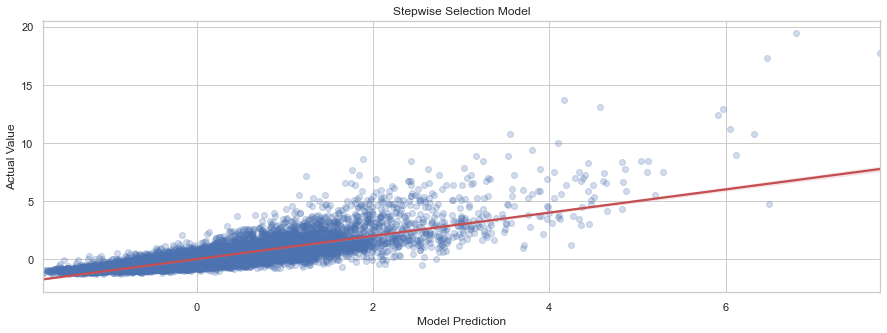

In [65]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, 
            scatter_kws = {'color':'b','alpha':0.25},color='r')
plt.title('Model A: All Features')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_A_regplot')

In [66]:
#get intercept
linreg.intercept_

-0.5501355394147065

In [67]:
#get coefficients and sort them
coefficients = dict(zip(X, list(linreg.coef_)))
dict(sorted(coefficients.items(), key = lambda item: item[1]))

{'zip_E': -0.13523211025571105,
 'base_1.0': -0.11066913362648272,
 'cond_2.0': -0.08210151123051065,
 'cond_3.0': -0.07800378763802499,
 'zip_D': -0.056853797808589145,
 'zip_C': 0.08376544156920224,
 'zip_A': 0.13896434716421488,
 'sqft_lot': 0.14314370392407588,
 'zip_B': 0.1622067074399148,
 'floors': 0.1772066572624472,
 'cond_5.0': 0.1798288831766555,
 'sqft_lot15': 0.21423240143100747,
 'age': 0.3292482733084551,
 'reno_1.0': 0.3446530600607672,
 'water_1.0': 0.47483510890551456,
 'sqft_above': 0.5372882770934383,
 'bedrooms': 0.7337234937057018,
 'bathrooms': 0.7858900555592192,
 'sqft_living15': 2.3149770267772416}

**Features that decreases value of the home:**

* 'zip_E': -0.1352321102557111
* 'base_1.0': -0.11066913362648224
* 'cond_2.0': -0.08210151123050968
* 'cond_3.0': -0.07800378763802439
* 'zip_D': -0.056853797808588506

**Features that increases value of the home:**
* 'zip_C': 0.08376544156920057
* 'zip_A': 0.13896434716421507
* 'floors': 0.14314370392407383
* 'zip_B': 0.16220670743991525
* 'bathrooms': 0.17720665726244916
* 'cond_5.0': 0.17982888317665507
* 'sqft_lot': 0.2142324014310095
* 'sqft_lot15': 0.3292482733084532
* 'reno_1.0': 0.3446530600607671
* 'water_1.0': 0.47483510890551595
* 'sqft_living15': 0.5372882770934395
* 'age': 0.733723493705701
* 'bedrooms': 0.7858900555592192
* 'sqft_above': 2.3149770267772416 

**Recheck for multicollinearity**

In [69]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

#recheck for multicollinearity
X = preprocessed_A[result_A]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])] 
list(zip(result_A, vif))

[('sqft_above', 3.148057722816477),
 ('age', 2.2423648207258178),
 ('water_1.0', 1.0400373391710502),
 ('bathrooms', 24.5808924376999),
 ('base_1.0', 2.7822492090783775),
 ('zip_A', 4.290652617544419),
 ('zip_C', 1.8249194859859676),
 ('sqft_living15', 2.6318276577199327),
 ('zip_B', 1.8220859772868632),
 ('bedrooms', 17.341313318594572),
 ('zip_G', 1.5956441254772722),
 ('zip_F', 1.459053857213612),
 ('cond_3.0', 4.023563239782995),
 ('reno_1.0', 1.1559974679711245),
 ('zip_E', 1.4476228181714277),
 ('zip_I', 1.1799199901382529),
 ('cond_5.0', 1.3350267944167478),
 ('floors', 14.997470031513634),
 ('cond_2.0', 1.0299440989722572)]

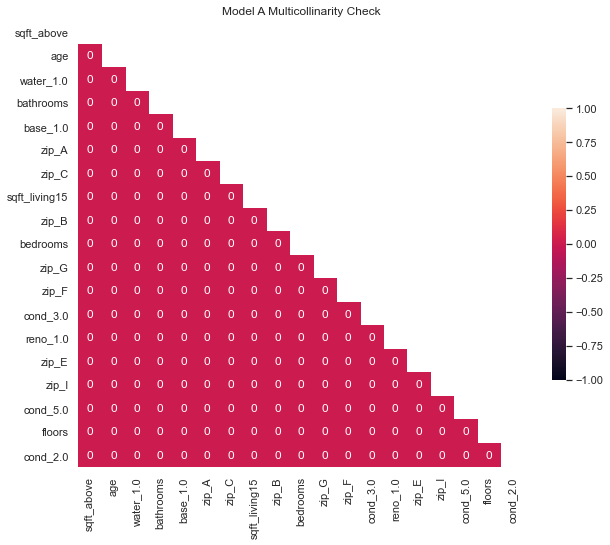

In [110]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_A].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_A].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    plt.title('Model A Multicollinarity Check')
plt.savefig('./Data & Figures/model_A_multicollinarity_check')

**Recheck for normality**

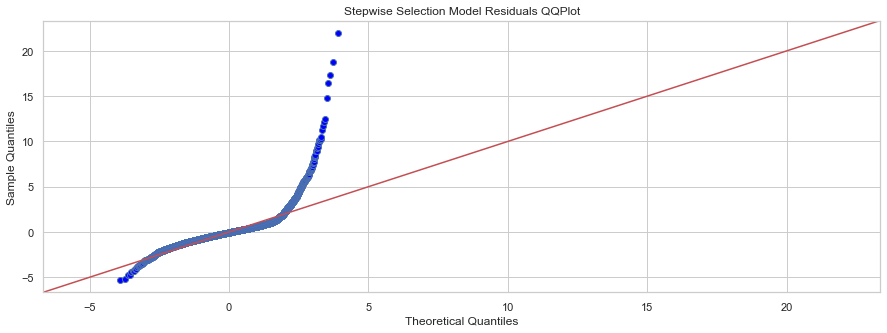

<Figure size 432x288 with 0 Axes>

In [71]:
#recheck for normality
fig = sm.graphics.qqplot(model_A.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model A Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_A_residuals_qqplot')

**Recheck for homoscedasticity**

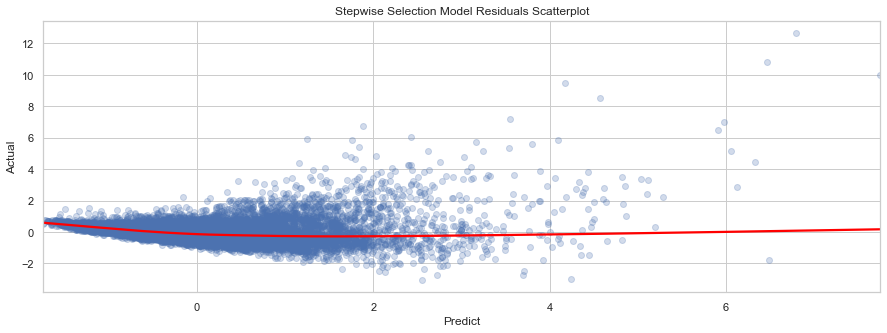

<Figure size 432x288 with 0 Axes>

In [73]:
#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_A.predict(), 
            y = model_A.resid, 
            lowess = True, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha':0.25}, color = 'r')
plt.title('Model A Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()
plt.savefig('./Data & Figures/model_A_homoscedasticity_regplot')

In [74]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_A.resid, model_A.model.exog)
list(zip(name, test))

[('F statistic', 1.0157928175913467), ('p-value', 0.20896254809615292)]

**Recheck for overfitting: K-Fold Cross Validation**

In [75]:
#cross-validation to check for overfitting
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

linreg = LinearRegression()

#get the mean squared error
mse = make_scorer(mean_squared_error)

cv_result = cross_val_score(linreg, X, y, cv = 10, scoring = 'neg_mean_squared_error')
cv_result

array([-0.44700717, -0.21879602, -0.29045251, -0.41047355, -0.31343039,
       -0.32220144, -0.30670357, -0.34794801, -0.40046316, -0.31142486])

In [76]:
#the accuracy of the model is the average of the accuracy of each fold
cv_result.mean()

-0.33689006785439585

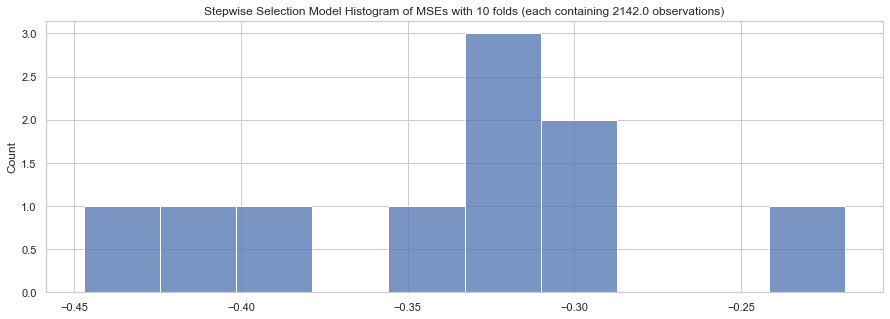

In [77]:
#visualize the cv_result
folds = 10
plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 10);
plt.title('Model A Histogram of MSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_A) / folds, 0)));
plt.savefig('./Data & Figures/model_A_cv_result_histplot')

Our regression visualization suggests that there are some splits for which our fitted model performs significantly less well.

## Validate Model A

In [78]:
#split the data into training and test sets. Use the default split size
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

17136 17136 4284 4284


In [79]:
#import and initialize the linear regression model class
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

To evaluate the model, we compare our predicted values, yhat with the actual value 𝑦 . The difference between the two values is referred to as the residuals. We'll compare our residuals for both test set and training set. To get a summarized measure over all the instances in the test set and training set, a popular metric is the RME (Root Mean Squared Error). A big difference in value between the test and training set (R)MSE is an indication of overfitting.

In [80]:
#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

In [81]:
#calculate training and test MSE
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print(train_mse)
print(test_mse)

0.3164361655406686
0.395227640275374


Our (R)MSE of train set and test set are quite similar, we  did not overfit the model.

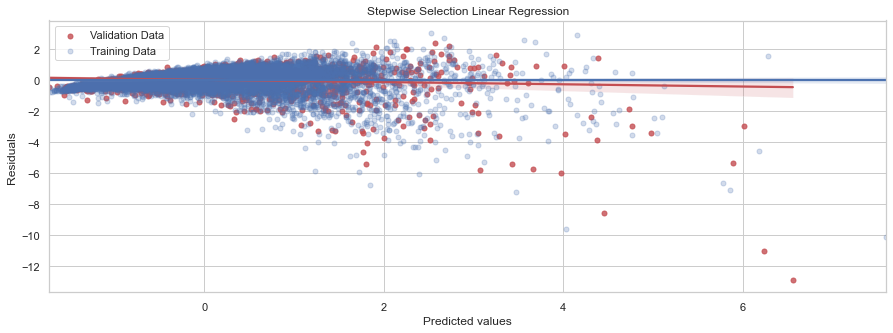

<Figure size 432x288 with 0 Axes>

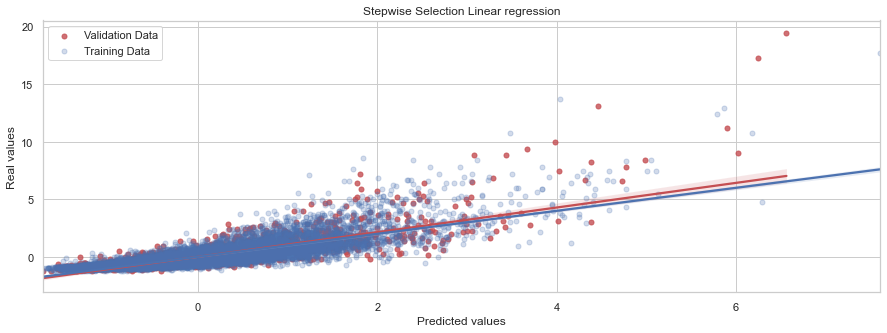

<Figure size 432x288 with 0 Axes>

In [86]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha':0.25}, fit_reg = True, label = 'Training Data')


plt.title('Model A: All Features')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_A_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,
            scatter_kws = {'s': 25}, color = 'r', 
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_train,
            scatter_kws = {'s': 25,'alpha':0.25}, 
            fit_reg = True, label = 'Training Data')

plt.title('Model A: All Features')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_A_predictions_regplot')

In [87]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
'Accuracy: {}%'.format(int(round(accuracy * 100)))

'Accuracy: 66%'

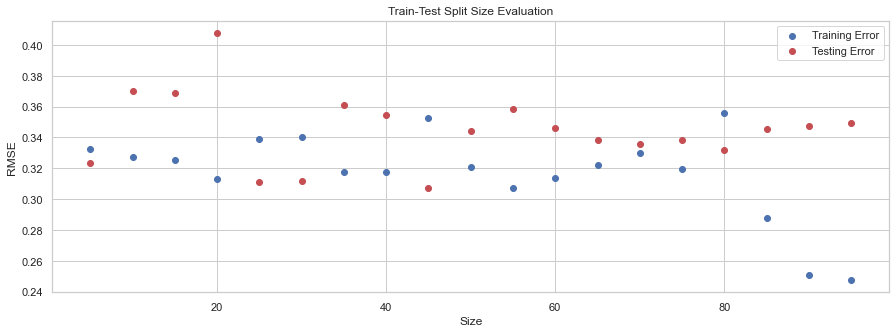

In [89]:
#evaluating the effect of train-test split size
import random
random.seed(11)

train_err = []
test_err = []
t_sizes = list(range(5, 100, 5))

for t_size in t_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = t_size / 100)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
    
plt.figure(figsize = (15, 5))    
plt.scatter(t_sizes, train_err, label = 'Training Error')
plt.scatter(t_sizes, test_err, label = 'Testing Error', color = 'r')
plt.title('Train-Test Split Size Evaluation')
plt.xlabel('Size')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('./Data & Figures/model_A_traintestsplit_scatterplot')

### Bias-Variance Tradeoff

In [90]:
# Transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Scale the train set
X_train_scaled = scaler.fit_transform(X_train)

# Scale the test set
X_test_scaled = scaler.transform(X_test)

In [91]:
# Training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

In [92]:
#function bias() to calculate the bias of a model's predictions given the actual data
def bias(y, y_hat):
    return np.mean(y_hat - y)

#function variance() to calculate the variance of a model's predictions
def variance(y_hat):
    return np.mean([yi**2 for yi in y_hat]) - np.mean(y_hat)**2

In [93]:
#bias and variance for training set 
b = bias(y_train, lm_train_predictions) 
v = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b, v))

Train bias: -0.013146483390592259 
Train variance: 0.17191439535139383


In [94]:
#bias and variance for test set 
b = bias(y_test, lm_test_predictions) 
v = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b, v))

Test bias: -0.019526280407220414 
Test variance: 0.17979501224284658


In [95]:
import pickle

#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_A.pkl','wb'))

In [98]:
#summary table
summary_table_1 = pd.DataFrame({'Model': [], 'Description':[], ' Num Features' : [], 
                                'r2': [], 'Accuracy':[], 
                                'Multicollinearity': [], 'Normality': [], 'Homoscedasticity': [], 
                                'Cross Validation': []})
summary_table_1.loc[0] = ['Model A', 'All features', len(result_A), 
                          r2_score(y, yhat), round(accuracy * 100), 
                          'P', 'F', 'F', 
                          cv_result.mean()]
summary_table_1.head()

,Model,Description,Num Features,r2,Accuracy,Multicollinearity,Normality,Homoscedasticity,Cross Validation
0,Model A,All features,19.0,0.668177,66.0,P,F,F,-0.33689


# MODEL B 
## REFINEMENT I: 
## REMOVE OUTLIERS THAT ARE 3 STD AWAY FROM THE MEAN

In [99]:
preprocessed_A.columns

Index(['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'age',
       'bedrooms', 'bathrooms', 'floors', 'water_1.0', 'base_1.0', 'reno_1.0',
       'cond_2.0', 'cond_3.0', 'cond_5.0', 'zip_A', 'zip_B', 'zip_C', 'zip_D',
       'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I'],
      dtype='object')

In [100]:
#removie outliers in 'bedrooms'
count = 0
bedrooms_outliers = []
mean = np.mean(preprocessed_A['bedrooms'])
std = np.std(preprocessed_A['bedrooms'])
cut_off = np.std(preprocessed_A['bedrooms']) * 3 

for idx, row in preprocessed_A['bedrooms'].T.iteritems():
    if abs(row - mean) >= cut_off:
        count += 1
        preprocessed_A.drop(idx, inplace = True)
count

61

In [101]:
#removie outliers in 'bathrooms'
count = 0
bathrooms_outliers = []
mean = np.mean(preprocessed_A['bathrooms'])
std = np.std(preprocessed_A['bathrooms'])
cut_off = np.std(preprocessed_A['bathrooms']) * 3 

for idx, row in preprocessed_A['bathrooms'].T.iteritems():
    if abs(row - mean) >= cut_off:
        count += 1
        preprocessed_A.drop(idx, inplace = True)
count

171

In [102]:
#excluding outliers
preprocessed_B = preprocessed_A[['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 
                                 'age', 'bedrooms', 'bathrooms', 'floors', 
                                 'water_1.0', 'base_1.0', 'reno_1.0',
                                 'cond_2.0', 'cond_3.0', 'cond_5.0', 
                                 'zip_A', 'zip_B', 'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

In [103]:
X = preprocessed_B.drop(['price'], axis = 1)
y = preprocessed_B['price']

In [104]:
len(result_A)

19

In [105]:
#feature ranking with recursive feature elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

#set number of features to be 13 to be consistent with previous Model 1 of Stepwise Selection
selector = RFE(linreg, n_features_to_select = 13) 

#convert y to 1d np array to prevent DataConversionWarning
selector = selector.fit(X, y.values.ravel()) 
selector.support_

array([ True, False,  True, False, False, False, False, False,  True,
        True,  True, False, False,  True,  True, False,  True,  True,
        True,  True, False,  True,  True])

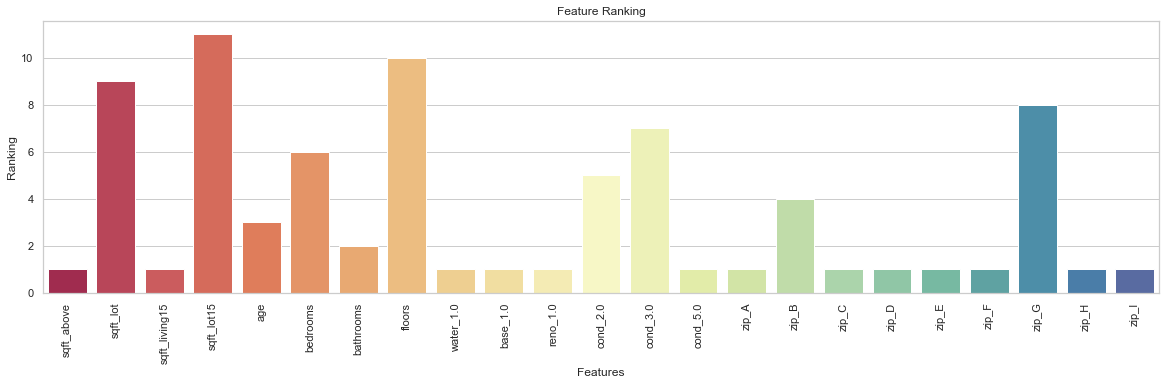

<Figure size 432x288 with 0 Axes>

In [106]:
#plot features ranking
plt.figure(figsize = (20, 5))
sns.barplot(x = X.columns, y = selector.ranking_, palette = 'Spectral');
plt.title('Model B: Outliers Removed + Feature Ranking')
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.xticks(rotation = 90)
plt.show()
plt.savefig('./Data & Figures/recursive_features_elimination')

In [107]:
#fit the linear regression model again using the selected columns
selected_features = X.columns[selector.support_ ]

linreg.fit(X[selected_features], y)

LinearRegression()

## Build Model B

In [108]:
#build model B in statsmodels
import statsmodels.api as sm

#interecept is not included by default and should be added manually
X_in = X[selected_features]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_B = sm.OLS(y, X_intercept).fit() 

#get summary
model_B.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     2970.
Date:                Tue, 26 Jan 2021   Prob (F-statistic):               0.00
Time:                        21:47:41   Log-Likelihood:                -16753.
No. Observations:               21188   AIC:                         3.353e+04
Df Residuals:                   21174   BIC:                         3.365e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.2249      0.008    -26.495      0.000      -0.242      -0.208
sqft_above        0.4486      0.006     72.861      0.000       0.437       0.461
sqft_living15     0.2213      0.006     36.475      0.000       0.209       0.233
water_1.0         2.1133      0.047     44.828      0.000       2.021       2.206
base_1.0          0.3382      0.008     40.063      0.000       0.322       0.355
reno_1.0          0.3267      0.020     15.990      0.000       0.287       0.367
cond_5.0          0.2310      0.014     16.753      0.000       0.204       0.258
zip_A             0.3622      0.011     32.737      0.000       0.341       0.384
zip_C             0.3372      0.013     25.397      0.000       0.311       0.363
zip_D            -0.4192      0.016    -26.669      0.000      -0.450      -0.388
zip_E            -0.2549      0.017    -14.968      0.000      -0.288      -0.222
zip_F            -0.5209      0.015    -33.725      0.000      -0.551      -0.491
zip_H            -0.4713      0.016    -29.136      0.000      -0.503      -0.440
zip_I            -0.2671      0.023    -11.459      0.000      -0.313      -0.221
==============================================================================
Omnibus:                    13250.452   Durbin-Watson:                   1.159
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           328483.030
Skew:                           2.588   Prob(JB):                         0.00
Kurtosis:                      21.582   Cond. No.                         16.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [109]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[selected_features], y)

#predict yhat using our model
yhat = linreg.predict(X[selected_features])
yhat

array([-0.9538422 , -0.54606172, -0.25866633, ..., -0.57466738,
       -0.28911522, -0.39310103])

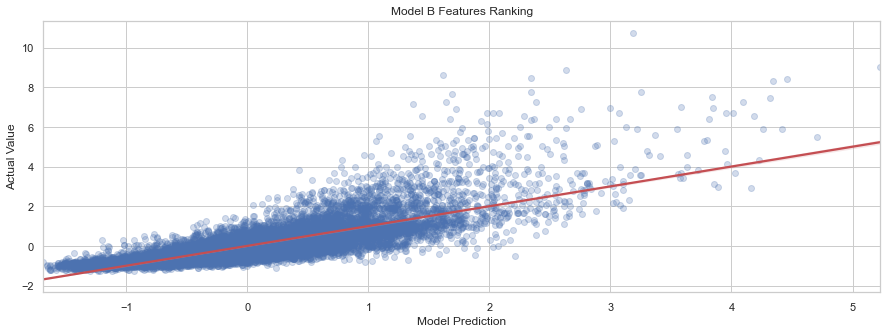

In [111]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, scatter_kws = {'color':'b','alpha':0.25},color='r')
plt.title('Model B: Outliers Removed + Feature Ranking')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_B_regplot')

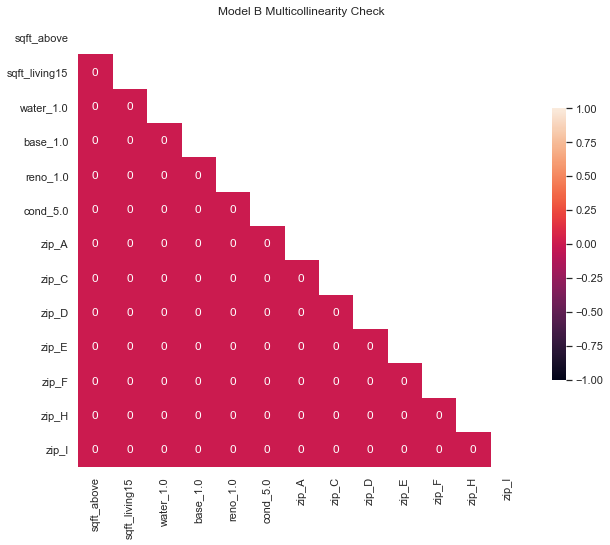

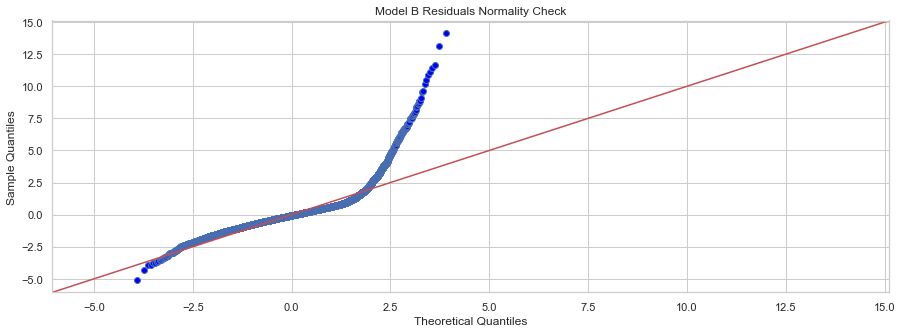

<Figure size 432x288 with 0 Axes>

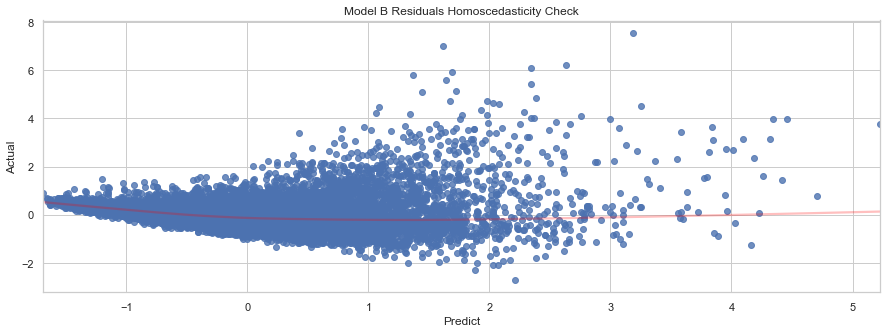

<Figure size 432x288 with 0 Axes>

In [114]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[selected_features].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[selected_features].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    plt.title('Model B Multicollinearity Check')
plt.savefig('./Data & Figures/model_B_multicollinarity_check')

#recheck for normality
fig = sm.graphics.qqplot(model_B.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model B Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_B_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_B.predict(), 
            y = model_B.resid, 
            lowess = True, 
            line_kws = {'color': 'red'},
            scatter_kws = {'s': 25,'alpha':0.25})
plt.title('Model B Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()
plt.savefig('./Data & Figures/model_B_homoscedasticity_regplot')

Without log-transformation of data, we keep failing the normality and homoscedasticity assumptions. 
For the next part of the project, we will use log-transformed features.

In [115]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_B.pkl','wb'))

In [116]:
summary_table_1.loc[1] = ['Model B', 'All features, outliers removed, RFE', len(selected_features), 
                          r2_score(y, yhat), round(accuracy * 100),
                         'P', 'F', 'F', 
                          'N/A']
summary_table_1.head()

,Model,Description,Num Features,r2,Accuracy,Multicollinearity,Normality,Homoscedasticity,Cross Validation
0,Model A,All features,19.0,0.668177,66.0,P,F,F,-0.33689
1,Model B,"All features, outliers removed, RFE",13.0,0.645805,66.0,P,F,F,N/A


# MODEL C
## MODEL REFINEMENT II:
## POLYNOMIAL REGRESSION

Without log-transformation of data, we keep failing the normality and homoscedasticity assumptions. The troublesome features are 'price', 'sqft_above', 'sqft_lot', 'sqft_living15', and 'sqft_lot15'.

Model C will be a refinement of Model A, since Model B (with outliers removed) did not improve and we don't want to remove outliers without a convincing reason.

In [129]:
#create new dataframe
preprocessed_C = preprocessed_A.copy(deep = True)

preprocessed_C.head(2)

,price,sqft_above,sqft_lot,sqft_living15,sqft_lot15,age,bedrooms,bathrooms,floors,water_1.0,...,cond_5.0,zip_A,zip_B,zip_C,zip_D,zip_E,zip_F,zip_G,zip_H,zip_I
15937,-0.740571,-1.099527,-0.169225,-1.441766,8100,0.955962,3,1.00,1.0,0,...,0,0,0,0,0,1,0,0,0,0
20963,-0.384457,-1.075393,-0.340062,-0.799934,1188,-1.357975,2,1.75,1.5,0,...,0,0,0,0,0,0,0,1,0,0


In [130]:
#transform non-normal features
preprocessed_C['sqft_above_poly'] = preprocessed_C['sqft_above']**2
preprocessed_C['sqft_lot_poly'] = preprocessed_C['sqft_lot']**2
preprocessed_C['sqft_living15_poly'] = preprocessed_C['sqft_living15']**2
preprocessed_C['sqft_lot15_poly'] = preprocessed_C['sqft_lot15']**2

In [131]:
#drop old values
preprocessed_C.drop(['sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'zip_C'], axis = 1, inplace = True)

In [132]:
#review dataframe
preprocessed_C.head(2)

,price,age,bedrooms,bathrooms,floors,water_1.0,base_1.0,reno_1.0,cond_2.0,cond_3.0,...,zip_D,zip_E,zip_F,zip_G,zip_H,zip_I,sqft_above_poly,sqft_lot_poly,sqft_living15_poly,sqft_lot15_poly
15937,-0.740571,0.955962,3,1.00,1.0,0,1,0,0,1,...,0,1,0,0,0,0,1.208959,0.028637,2.078689,65610000
20963,-0.384457,-1.357975,2,1.75,1.5,0,1,0,0,1,...,0,0,0,1,0,0,1.156469,0.115642,0.639894,1411344


In [133]:
#redefine X_train and y_train
X = preprocessed_C.drop(['price'], axis = 1)
y = preprocessed_C['price']

In [134]:
#apply stepwise function to make sure we only select impactful features
result_C = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_C)

Add  sqft_above_poly                with p-value 0.0
Add  bedrooms                       with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  age                            with p-value 0.0
Add  water_1.0                      with p-value 1.46577e-288
Add  sqft_living15_poly             with p-value 1.25711e-235
Add  zip_F                          with p-value 1.66356e-231
Add  zip_D                          with p-value 2.80622e-226
Add  zip_H                          with p-value 7.80799e-221
Add  zip_E                          with p-value 3.93687e-231
Add  zip_I                          with p-value 8.67926e-51
Add  zip_G                          with p-value 2.02275e-31
Add  cond_3.0                       with p-value 1.0742e-19
Add  reno_1.0                       with p-value 7.52692e-21
Add  zip_B                          with p-value 1.5015e-17
Add  zip_A                          with p-value 1.59636e-53
Add  floors                         with p-value 2.2

In [135]:
#interecept is not included by default and should be added manually
X_in = X[result_C]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_C = sm.OLS(y, X_intercept).fit() 

#get summary
model_C.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     1496.
Date:                Tue, 26 Jan 2021   Prob (F-statistic):               0.00
Time:                        21:59:26   Log-Likelihood:                -18414.
No. Observations:               21188   AIC:                         3.687e+04
Df Residuals:                   21167   BIC:                         3.704e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.1557      0.024    -47.896      0.000      -1.203      -1.108
sqft_above_poly        0.1071      0.003     37.081      0.000       0.101       0.113
bedrooms               0.0499      0.006      9.011      0.000       0.039       0.061
bathrooms              0.4561      0.009     51.732      0.000       0.439       0.473
age                    0.1635      0.006     26.241      0.000       0.151       0.176
water_1.0              2.2101      0.051     43.271      0.000       2.110       2.310
sqft_living15_poly     0.0867      0.003     30.962      0.000       0.081       0.092
zip_F                 -0.9292      0.019    -50.218      0.000      -0.965      -0.893
zip_D                 -0.8682      0.019    -46.303      0.000      -0.905      -0.831
zip_H                 -0.8290      0.019    -42.724      0.000      -0.867      -0.791
zip_E                 -0.7934      0.020    -39.596      0.000      -0.833      -0.754
zip_I                 -0.5876      0.027    -21.998      0.000      -0.640      -0.535
zip_G                 -0.3687      0.018    -20.295      0.000      -0.404      -0.333
cond_3.0              -0.0802      0.010     -8.378      0.000      -0.099      -0.061
reno_1.0               0.1925      0.023      8.301      0.000       0.147       0.238
zip_B                 -0.2611      0.016    -16.304      0.000      -0.293      -0.230
zip_A                 -0.2987      0.015    -19.806      0.000      -0.328      -0.269
floors                 0.1565      0.010     14.987      0.000       0.136       0.177
base_1.0               0.1402      0.010     14.232      0.000       0.121       0.159
sqft_lot_poly          0.0014      0.000      5.994      0.000       0.001       0.002
cond_2.0              -0.2440      0.046     -5.301      0.000      -0.334      -0.154
==============================================================================
Omnibus:                    11095.191   Durbin-Watson:                   1.178
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           183460.425
Skew:                           2.138   Prob(JB):                         0.00
Kurtosis:                      16.767   Cond. No.                         216.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [136]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[result_C], y)

#predict yhat using our model
yhat = linreg.predict(X[result_C])
yhat

array([-0.66069269, -0.37408616, -0.16870722, ..., -1.13025059,
       -0.39147301, -0.23617314])

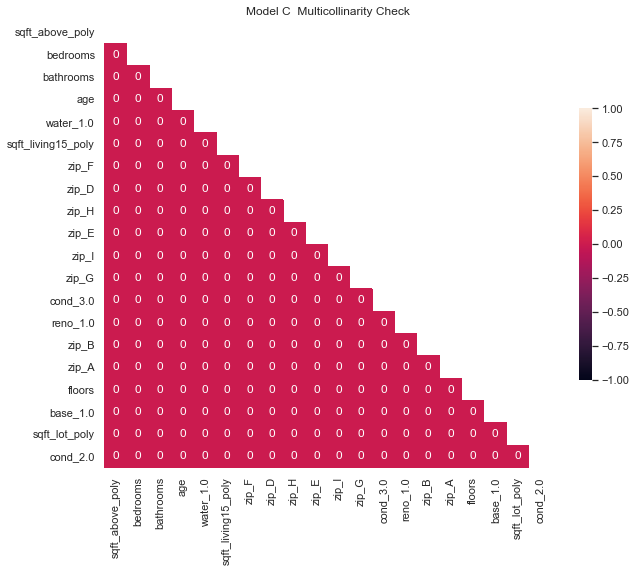

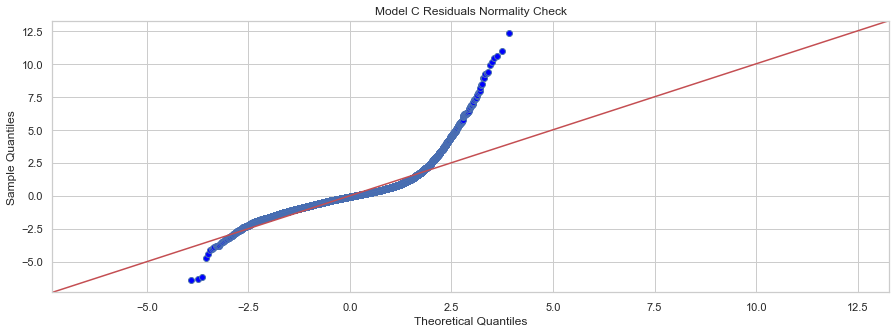

<Figure size 432x288 with 0 Axes>

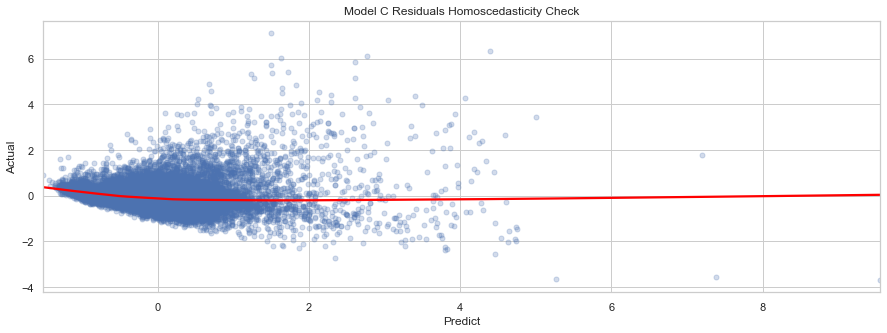

<Figure size 432x288 with 0 Axes>

In [139]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_C].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_C].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    plt.title('Model C  Multicollinarity Check')
plt.savefig('./Data & Figures/model_C_multicollinarity_check')

#recheck for normality
fig = sm.graphics.qqplot(model_C.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model C Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_C_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_C.predict(), 
            y = model_C.resid, 
            lowess = True, 
            line_kws = {'color': 'red'},
            scatter_kws = {'s': 25,'alpha':0.25})
plt.title('Model C Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()
plt.savefig('./Data & Figures/model_C_homoscedasticity_regplot')

In [140]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_C.resid, model_C.model.exog)
list(zip(name, test))

[('F statistic', 1.1479812614688005), ('p-value', 6.599473156225273e-13)]

In [141]:
#split the data into training and test sets. Use the default split size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print(train_mse)
print(test_mse)

16950 16950 4238 4238
0.33032839845492884
0.3433812467152978


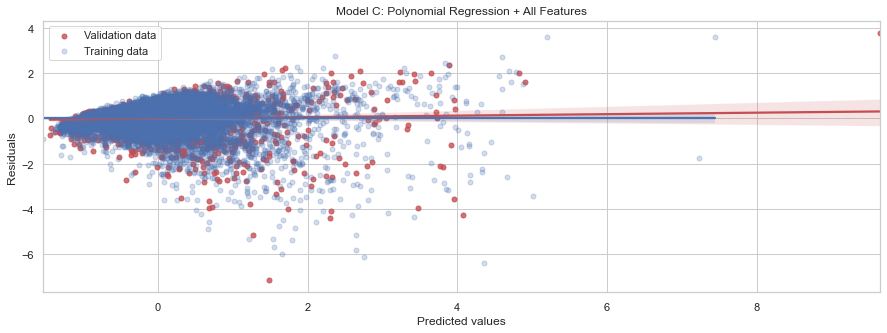

<Figure size 432x288 with 0 Axes>

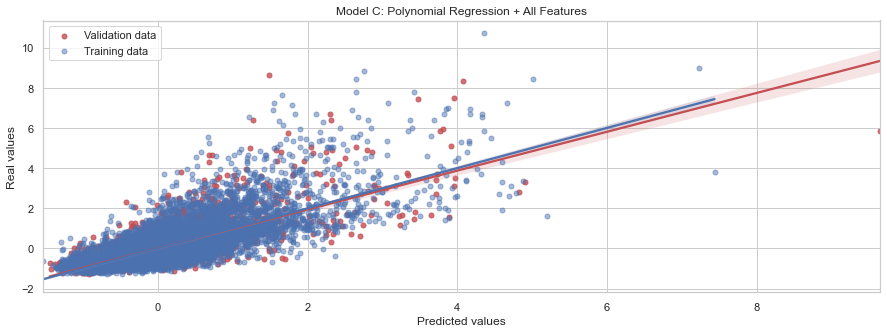

<Figure size 432x288 with 0 Axes>

In [151]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test, 
                scatter_kws = {'s': 25}, color = 'r',
            fit_reg = True, label = 'Validation data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train, 
                scatter_kws = {'s': 25,'alpha': 0.25}, 
            fit_reg = True, label = 'Training data')

plt.title('Model C: Polynomial Regression + All Features')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = "upper left")
plt.show()
plt.savefig('./Data & Figures/model_C_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test, color = 'r',
                scatter_kws = {'s': 25}, 
            fit_reg = True, label = 'Validation data')
sns.regplot(x = y_hat_train, y = y_train,  
                scatter_kws = {'s': 25,'alpha': 0.5}, fit_reg = True, label = 'Training data')

plt.title('Model C: Polynomial Regression + All Features')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_C_predictions_regplot')

In [142]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 57%'

In [143]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_C.pkl','wb'))

In [144]:
summary_table_1.loc[2] = ['Model C', 'Poly, All features', len(result_C), 
                          r2_score(y, yhat), round(accuracy * 100),
                         'P', 'F', 'F', 
                          'N/A']
summary_table_1.head()

,Model,Description,Num Features,r2,Accuracy,Multicollinearity,Normality,Homoscedasticity,Cross Validation
0,Model A,All features,19.0,0.668177,66.0,P,F,F,-0.33689
1,Model B,"All features, outliers removed, RFE",13.0,0.645805,66.0,P,F,F,N/A
2,Model C,"Poly, All features",20.0,0.585675,57.0,P,F,F,N/A


# MODEL D
## MODEL REFINEMENT II: 
## LOG TRANSFORM NON-NORMAL CONTINUOUS FEATURES

In [152]:
preprocessed_log_D = clean[['price', 'sqft_above_log', 'sqft_lot_log', 'sqft_living15_log',
                            'age', 'bedrooms', 'bathrooms', 'floors',
                            'water_1.0', 'base_1.0', 'reno_1.0',
                            'cond_2.0', 'cond_3.0', 'cond_5.0',
                            'zip_A', 'zip_B', 'zip_C', 'zip_E', 'zip_D', 'zip_F', 'zip_G', 'zip_H', 'zip_I', 
                            'zipcode']]

In [155]:
preprocessed_log_D.drop('sqft_living15_log', axis = 1, inplace = True)

In [156]:
X = preprocessed_log_D.drop(['price'], axis=1)
y = preprocessed_log_D['price']

In [157]:
#apply stepwise function
result_D = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_D)

Add  floors                         with p-value 0.0
Add  water_1.0                      with p-value 0.0
Add  sqft_above_log                 with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  age                            with p-value 0.0
Add  zip_A                          with p-value 5.74197e-308
Add  zip_C                          with p-value 0.0
Add  zip_B                          with p-value 1.81737e-207
Add  base_1.0                       with p-value 3.74648e-157
Add  zip_G                          with p-value 5.87436e-143
Add  bedrooms                       with p-value 2.23036e-97
Add  sqft_lot_log                   with p-value 1.25824e-21
Add  zip_F                          with p-value 2.31445e-16
Add  zip_I                          with p-value 1.8978e-10
Add  zip_E                          with p-value 2.72748e-09
Add  zipcode                        with p-value 5.25338e-18
Add  cond_5.0                       with p-value 1.60338e-06
Add  ren

### Build Model D

In [158]:
#build model in statsmodels
import statsmodels.api as sm

#interecept is not included by default and should be added manually
X_in = X[result_D]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_D = sm.OLS(y, X_intercept).fit() 

#get summary
model_D.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     1645.
Date:                Tue, 26 Jan 2021   Prob (F-statistic):               0.00
Time:                        22:15:31   Log-Likelihood:                -20421.
No. Observations:               21420   AIC:                         4.088e+04
Df Residuals:                   21399   BIC:                         4.105e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            120.6712     14.249      8.469      0.000      92.742     148.600
floors            -0.0571      0.013     -4.568      0.000      -0.082      -0.033
water_1.0          2.4647      0.053     46.491      0.000       2.361       2.569
sqft_above_log     1.2888      0.020     65.499      0.000       1.250       1.327
bathrooms          0.3233      0.010     32.348      0.000       0.304       0.343
age                0.1594      0.007     23.311      0.000       0.146       0.173
zip_A             13.9449      1.594      8.750      0.000      10.821      17.069
zip_C             13.9457      1.577      8.842      0.000      10.854      17.037
zip_B             13.5943      1.580      8.605      0.000      10.498      16.691
base_1.0           0.3359      0.011     29.940      0.000       0.314       0.358
zip_G             13.4989      1.580      8.543      0.000      10.402      16.596
bedrooms          -0.1247      0.006    -20.116      0.000      -0.137      -0.113
sqft_lot_log       0.0576      0.006      9.037      0.000       0.045       0.070
zip_F             12.9378      1.577      8.204      0.000       9.847      16.029
zip_I             13.2775      1.581      8.398      0.000      10.178      16.377
zip_E             13.3577      1.599      8.353      0.000      10.223      16.492
zipcode           -0.0015      0.000     -9.129      0.000      -0.002      -0.001
cond_5.0           0.0716      0.018      4.056      0.000       0.037       0.106
reno_1.0           0.1150      0.025      4.615      0.000       0.066       0.164
zip_D             13.1003      1.583      8.273      0.000       9.997      16.204
zip_H             13.0142      1.578      8.245      0.000       9.920      16.108
cond_3.0          -0.0338      0.011     -3.099      0.002      -0.055      -0.012
==============================================================================
Omnibus:                    19782.916   Durbin-Watson:                   1.320
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2470685.080
Skew:                           4.031   Prob(JB):                         0.00
Kurtosis:                      54.993   Cond. No.                     1.29e+21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.24e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [159]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[result_D], y)

#predict yhat using our model
yhat = linreg.predict(X[result_D])
yhat

array([-1.13226041, -0.9074637 , -0.74428667, ..., -0.76830601,
       -0.57910722, -0.38958079])

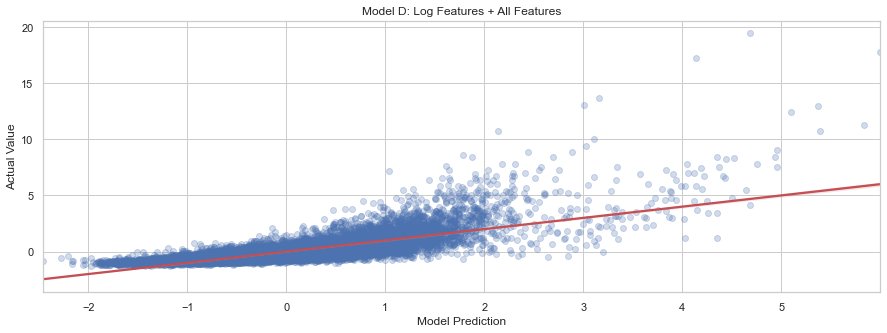

In [160]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, scatter_kws = {'color':'b','alpha': 0.25},color='r')
plt.title('Model D: Log Features + All Features')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_2_scatterplot')

In [161]:
#get intercept
linreg.intercept_

134.0790709019812

### Test Model D

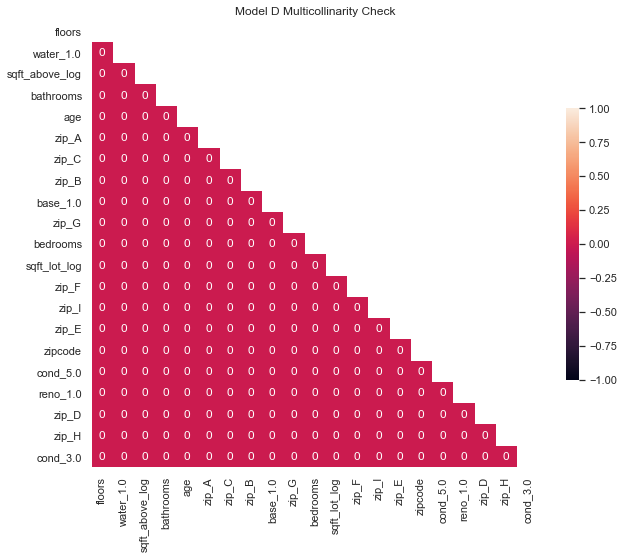

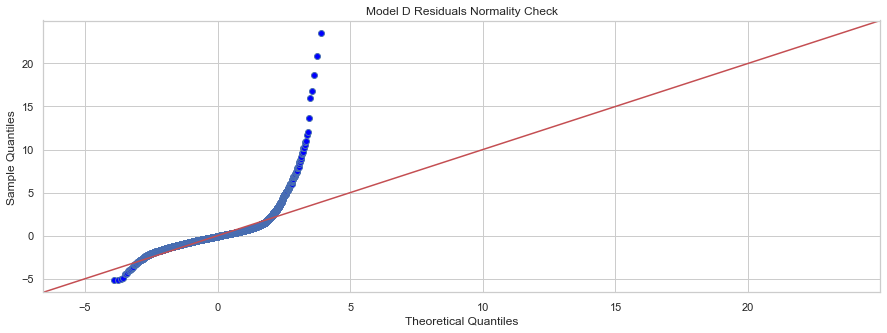

<Figure size 432x288 with 0 Axes>

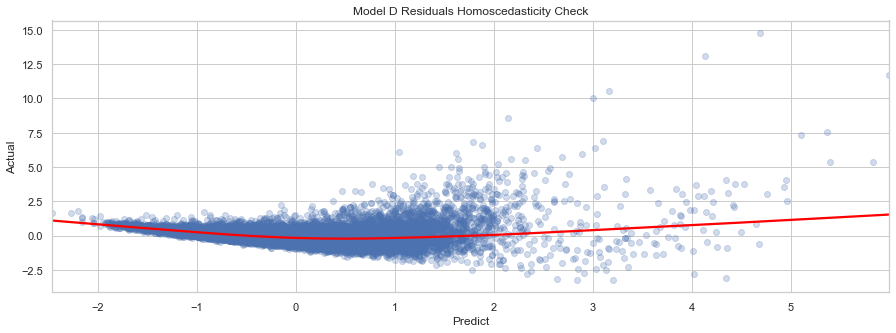

<Figure size 432x288 with 0 Axes>

In [163]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_D].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_D].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    plt.title('Model D Multicollinarity Check')
plt.savefig('./Data & Figures/model_D_multicollinarity_check')

#recheck for normality
fig = sm.graphics.qqplot(model_D.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model D Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_D_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_D.predict(), 
            y = model_D.resid, 
            lowess = True, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha': 0.25}, color = 'r')
plt.title('Model D Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()
plt.savefig('./Data & Figures/model_D_homoscedasticity_regplot')

In [164]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_D.resid, model_D.model.exog)
list(zip(name, test))

[('F statistic', 1.0220881973137965), ('p-value', 0.12937348540401764)]

In [165]:
#split the data into training and test sets. Use the default split size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print(train_mse)
print(test_mse)

17136 17136 4284 4284
0.37070329421779447
0.4893774108942037


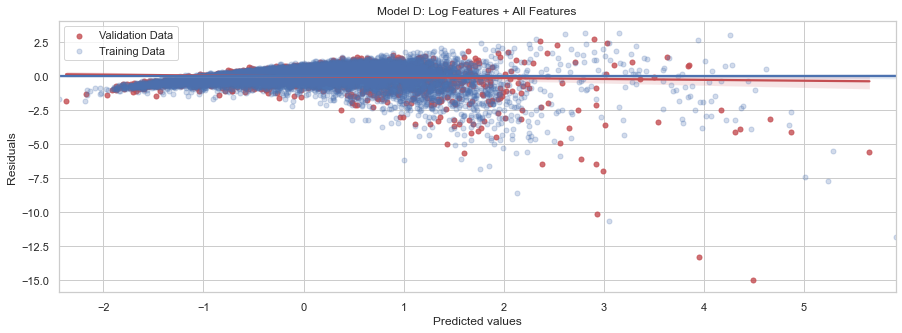

<Figure size 432x288 with 0 Axes>

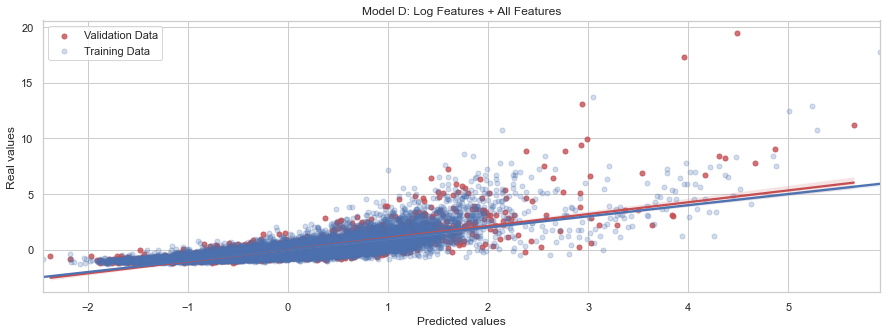

<Figure size 432x288 with 0 Axes>

In [170]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha':0.25}, fit_reg = True, label = 'Training Data')


plt.title('Model D: Log Features + All Features')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_D_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,
            scatter_kws = {'s': 25}, color = 'r', 
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_train,
            scatter_kws = {'s': 25,'alpha':0.25}, 
            fit_reg = True, label = 'Training Data')

plt.title('Model D: Log Features + All Features')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_D_predictions_regplot')

In [166]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 58%'

In [167]:
#cross-validation to check for overfitting
linreg = LinearRegression()

#get the mean squared error
mse = make_scorer(mean_squared_error)

cv_result = cross_val_score(linreg, X, y, cv = 10, scoring = 'neg_mean_squared_error')
print(cv_result.mean())

-0.3978765700510425


In [168]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_D.pkl','wb'))

In [169]:
#update summary
summary_table_1.loc[3] = ['Model D', 'Log features, All features', len(result_D), 
                          r2_score(y, yhat), round(accuracy * 100),
                         'P', 'F', 'F',
                         cv_result.mean()]
summary_table_1.head()

,Model,Description,Num Features,r2,Accuracy,Multicollinearity,Normality,Homoscedasticity,Cross Validation
0,Model A,All features,19.0,0.668177,66.0,P,F,F,-0.33689
1,Model B,"All features, outliers removed, RFE",13.0,0.645805,66.0,P,F,F,N/A
2,Model C,"Poly, All features",20.0,0.585675,57.0,P,F,F,N/A
3,Model D,"Log features, All features",21.0,0.605890,58.0,P,F,F,-0.397877
